In [1]:
%run init_notebookspace.py
from settings import *

## Table of Content
* [Introduction](#chapter0)
* [Make RBC Model](#chapter3)
    * [Model Equations](#section_3_1)
    * [Find Steady State, Solve the Model](#section_3_2)
    * [Check Blanchard Kahn Conditions](#section_3_3)
* [Maximum Likelihood Estimation](#chapter4)
    * [A Simple Model](#section_4_1)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_1)
        * [Forecasting](#subsection_4_2)
    * [A Noisy Model](#section_4_2)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_3)
        * [Forecasting](#subsection_4_4)
    * [Adding Variables](#section_4_3)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_5)
        * [Forecasting](#subsection_4_6)
    * [Final Model](#section_4_4)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_7)
        * [Forecasting](#subsection_4_8)
    * [Impulse response](#section_4_5)
        * [New Steady State](#subsection_4_9)

## Introduction <a class="anchor" id="chapter0"></a>

The aim of this paper is to fit the RBC model for Italy. 
The source of all the data is the National Institute of Statistics of Italy (ISTAT) and his database. 
The parameters use instead are taken from
1. the official site of the Bank of Italy (https://www.bancaditalia.it/compiti/ricerca-economica/modelli-macroeconomici/index.html?com.dotmarketing.htmlpage.language=1)
2.  Jerger, Jürgen; Röhe, Oke (2012) : Testing for Parameter Stability in DSGE Models. The Cases of France, Germany, Italy, and Spain, BGPE Discussion Paper, No. 118, Friedrich-Alexander-Universität Erlangen-Nürnberg, Bavarian Graduate Program in Economics (BGPE), Nürnberg 
3. Gottlieb, Onken, Valladares-Esteban (2021): On the Measurement of the Elasticity of Labour, European Economic Review, Volume 139, 103879, ISSN 0014-2921
4. Marino (2016) : The Italian productivity solwdown in a Real Business Cycle perspective, Int Rev Econ, 63, pages 171-193.


In [2]:
%matplotlib inline
import gEcon as ge
import gEcon.plotting as gp
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az

import os
import statsmodels.api as sm
import statsmodels
import scipy

from src.utils import time_format, plot_df, get_seasonal_hp, arr_adf, apply_func, poly_detrend, ADF_test_summary, plot_sm_results
from src.utils import get_max_seasonal, OLS_dummie_deseasonal

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 0.0068, 'delta':0.01, 'rho_A': 0.9405}
plot_vars = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r', 'w']
maxiter = 1

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()
    pass

In [4]:
# load data
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

# drop csv index
train.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

# time format index
train['TIME'] = time_format(train.TIME)
test['TIME'] = time_format(test.TIME)

# set index - get's lost with csv
train.set_index('TIME', inplace=True)
test.set_index('TIME', inplace=True)

# asign correct time freq
train = train.asfreq('QS')
test = test.asfreq('QS')

glob_cols = list(train.columns)
test_size = len(test)

# RBC Model <a class="anchor" id="chapter3"></a>

Loading the model and solving for steady state

In [5]:
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc_basic.gnc'))

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	6 parameters
		 0 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations <a class="anchor" id="section_3_1"></a>

In [6]:
for equation in rbc.system_equations:
    display(equation)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Find Steady State, Solve the Model <a class="anchor" id="section_3_2"></a>

In [7]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 1.47501368398038e-19
Solution found, sum of squared residuals:  4.0781870427091863e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


Steady state values according to the parameters literature suggests for Italy. These were specified in the GCN file.

In [8]:
rbc.print_steady_state()

A_ss               1.000
C_ss               6.790
I_ss               1.018
K_ss             101.771
L_ss               3.138
Y_ss               7.808
lambda_ss          0.987
r_ss               0.020
w_ss               1.836


## Check Blanchard Kahn Conditions <a class="anchor" id="section_3_3"></a>

As we know from theory the Blanchard condition are important because they let us understand if the model has a unique solution through the steady state.

In [9]:
rbc.check_bk_condition()

Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


,Modulus,Real,Imaginary
0,1.381675e-19,1.381675e-19,0.0
1,1.654782e-17,1.654782e-17,0.0
2,2.750983e-17,2.750983e-17,0.0
3,5.917828e-17,5.917828e-17,0.0
4,7.395453e-01,7.395453e-01,0.0
5,9.405000e-01,9.405000e-01,0.0
6,1.365841e+00,1.365841e+00,0.0
7,4.696784e+06,4.696784e+06,0.0


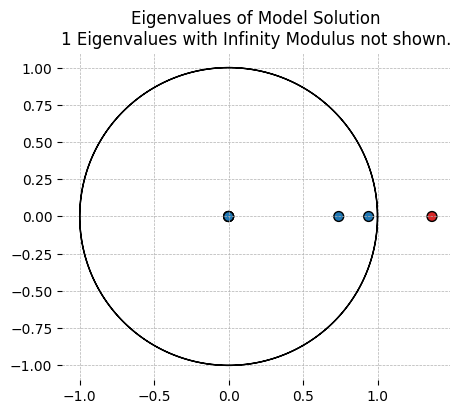

In [10]:
gp.plot_eigenvalues(rbc);

As we can see the output the number of unstable variables is the same as the number of control variable as a consequence the system has a unique solution.

In [11]:
#Run IRFs with our starting parameters to compare with the estimated parameters at the end.
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

# Maximum Likelihood Estimation <a class="anchor" id="chapter4"></a>

In [12]:
# assign date freq
train = train.asfreq("QS")
train.head()

,Y,I,r,C,w,L
TIME,,,,,,
1996-01-01,0.034739,0.025376,0.030090,0.073761,NaN,0.006896
1996-04-01,-0.023203,0.006568,0.023159,-0.032295,NaN,NaN
1996-07-01,-0.047401,-0.006060,0.019601,-0.077407,NaN,NaN
1996-10-01,-0.040238,-0.003936,0.010456,-0.046165,NaN,NaN
1997-01-01,-0.037205,-0.012070,0.009416,-0.052189,NaN,-0.005354


## Simple model <a class="anchor" id="section_4_1"></a>

In [13]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [14]:
# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
#     'Y':0.01,
#     'C':0.02,
#     'L':0.05,
#     'I':0.02,
#     'r':0.03,
#     'w':0.1
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
#     'sigma_C': IntervalTransformer(low=1.05, high=10.0, slope=1),
#     'sigma_L': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
    # 'alpha':IntervalTransformer(low=0.0001, high=0.99, slope=1)
}

mle_mod = MLEModel(train[["Y"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [15]:
%%capture
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=maxiter)

In [16]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                   80
Model:                      DSGEModel   Log Likelihood                  32.505
Date:                Fri, 09 Dec 2022   AIC                            -61.011
Time:                        23:49:15   BIC                            -56.247
Sample:                    01-01-1996   HQIC                           -59.101
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.8913      0.159      5.591      0.000       0.579       1.204
sigma2.epsilon_A     0.0170      0.004      4.216      0.000       0.009       0.025
===================================================================================
Ljung-Box (L1) (Q):                   8.66   Jarque-Bera (JB):               295.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -1.92
Prob(H) (two-sided):                  0.08   Kurtosis:                        11.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

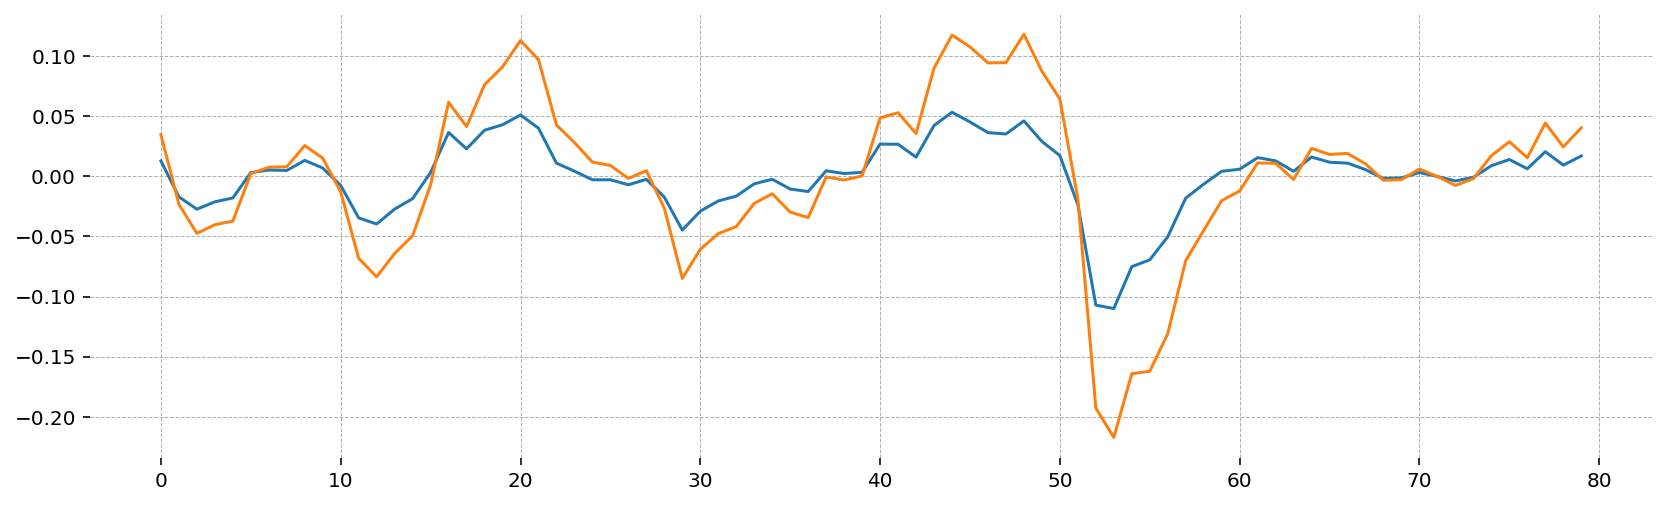

In [17]:
# without any observation noise the 'filter' output should equal the data, why not the case ??
plt.plot(mle_res.filtered_state[0])
plt.plot(train.Y.values)

### MLE Kalman Filter Prediction Plots <a class="anchor" id="subsection_4_1"></a>

Predictions

The model does not correctly pick-up on the data's variance and its direction. Confidence intervals are rather broad and predicted variation moves even in the opposite direction with C. Deviations differ significantly in magnitude from the actual data, thus even variance has not been captured correctly. Especially consumption and labour are much less responsive to variations in Y in reality than suggested by the model. This might point to a too responsive specification of the consumption function.

However, there is light at the end of the tunel. Towards the end of our observation period the model doe seem to predict variation to some extend consistend with the data. Consumption, Labour and Investment slightly rise and so do the model predictions. Yet even these more correct predictions are subject to very broad confidence intervals. Moreover, the model predicts for wages to go down the same time, which is not the case.

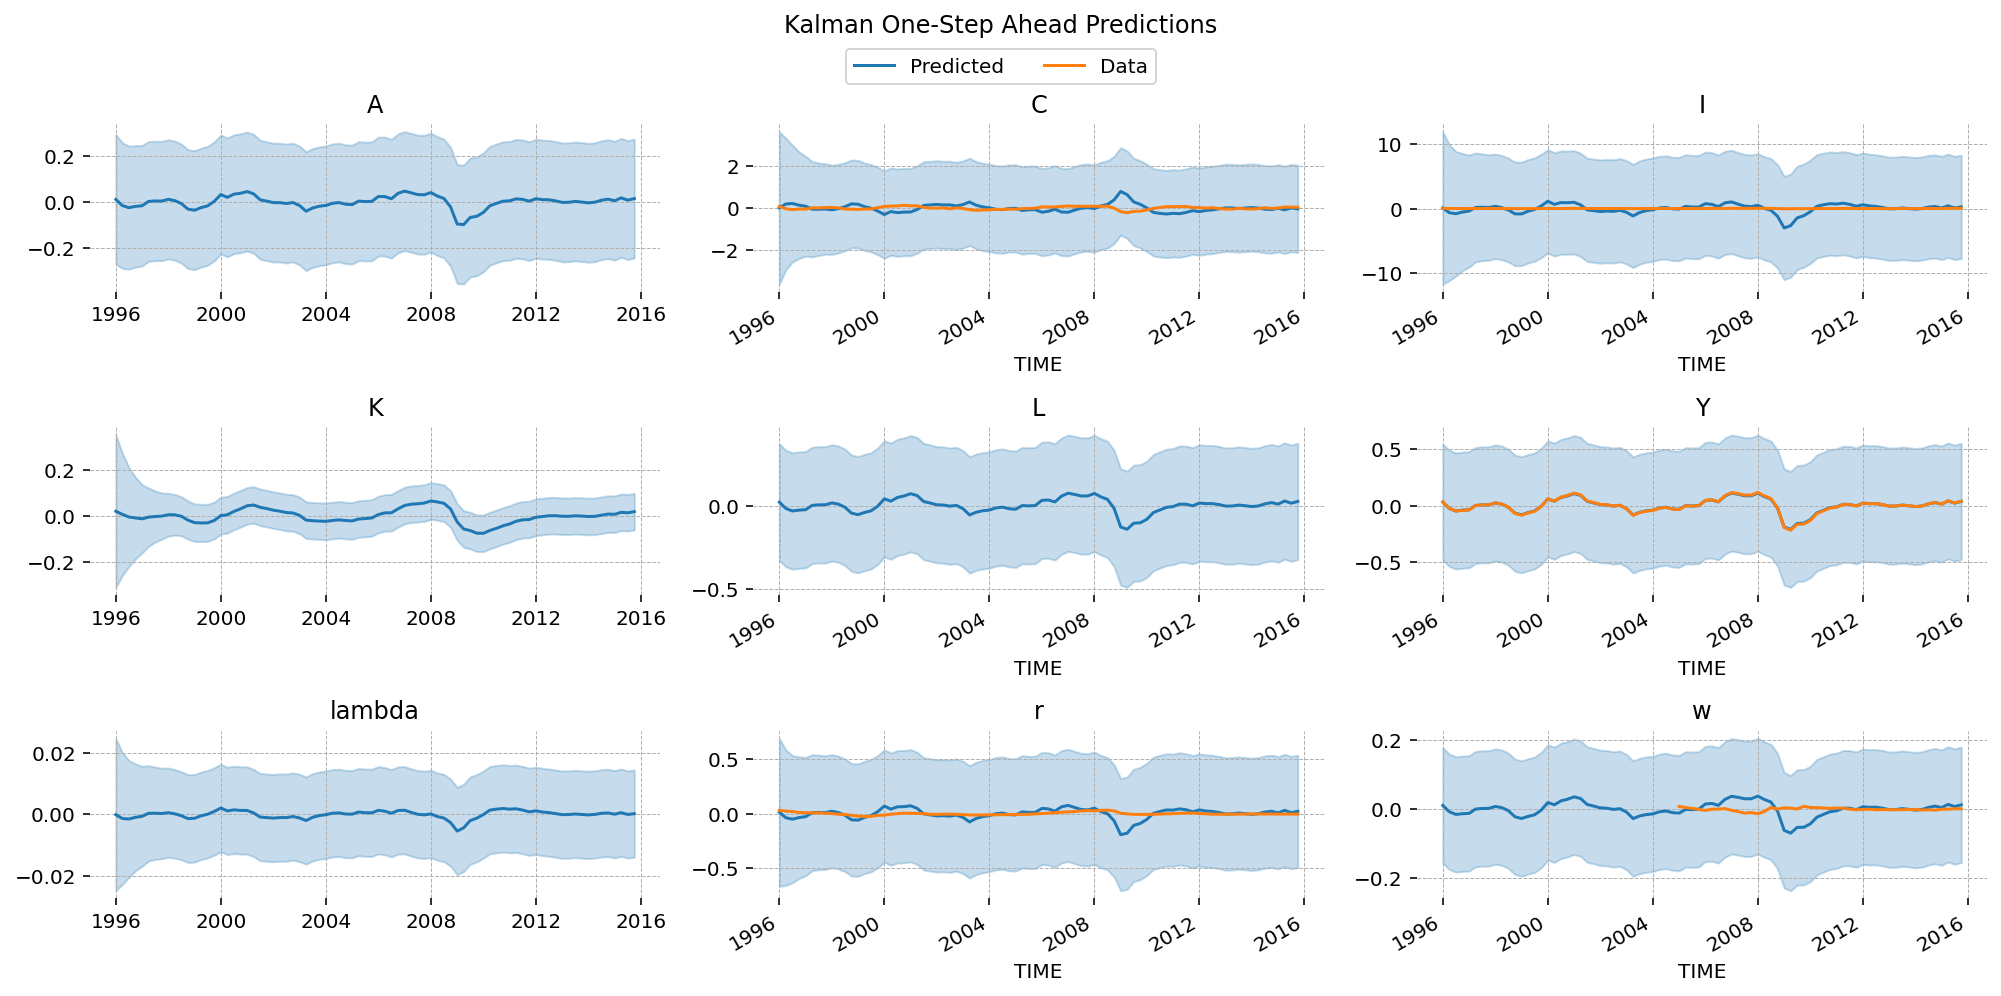

In [18]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

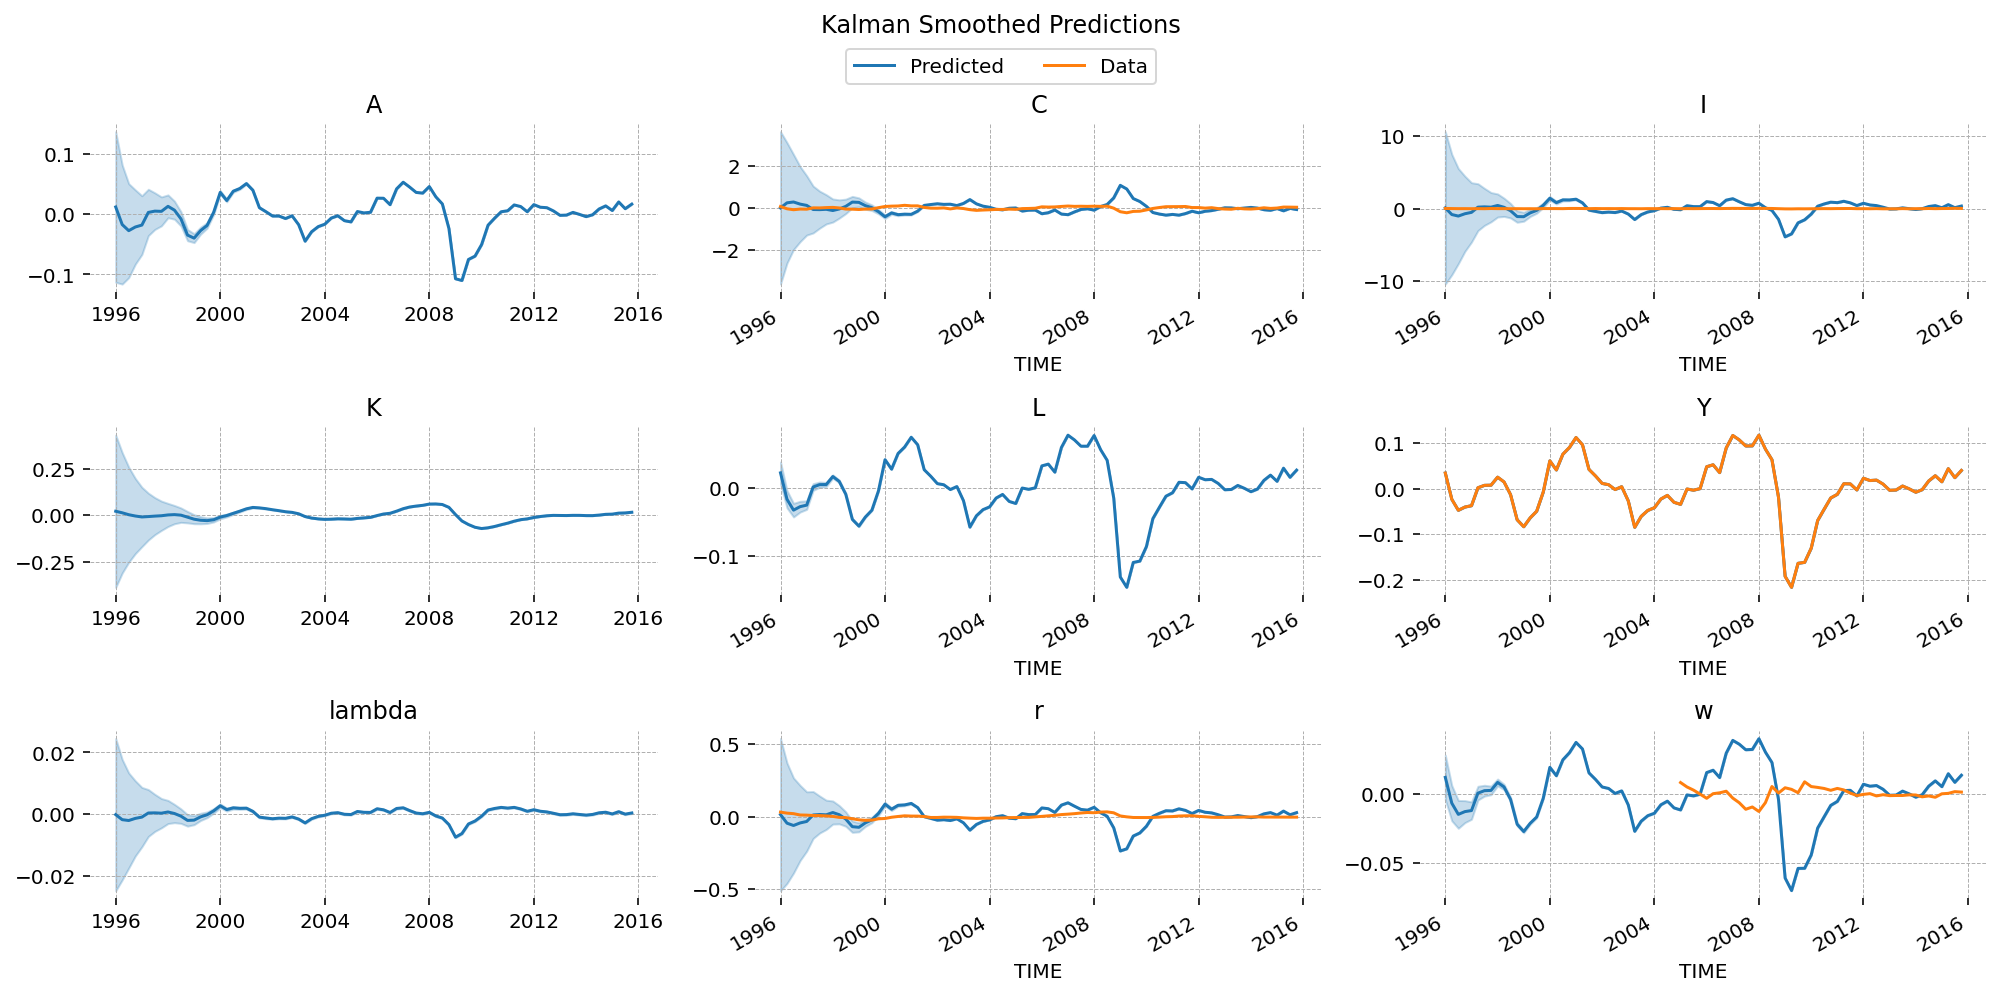

In [19]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="subsection_4_2"></a>

In [20]:
mle_forecast = mle_res.get_forecast(steps=test_size)

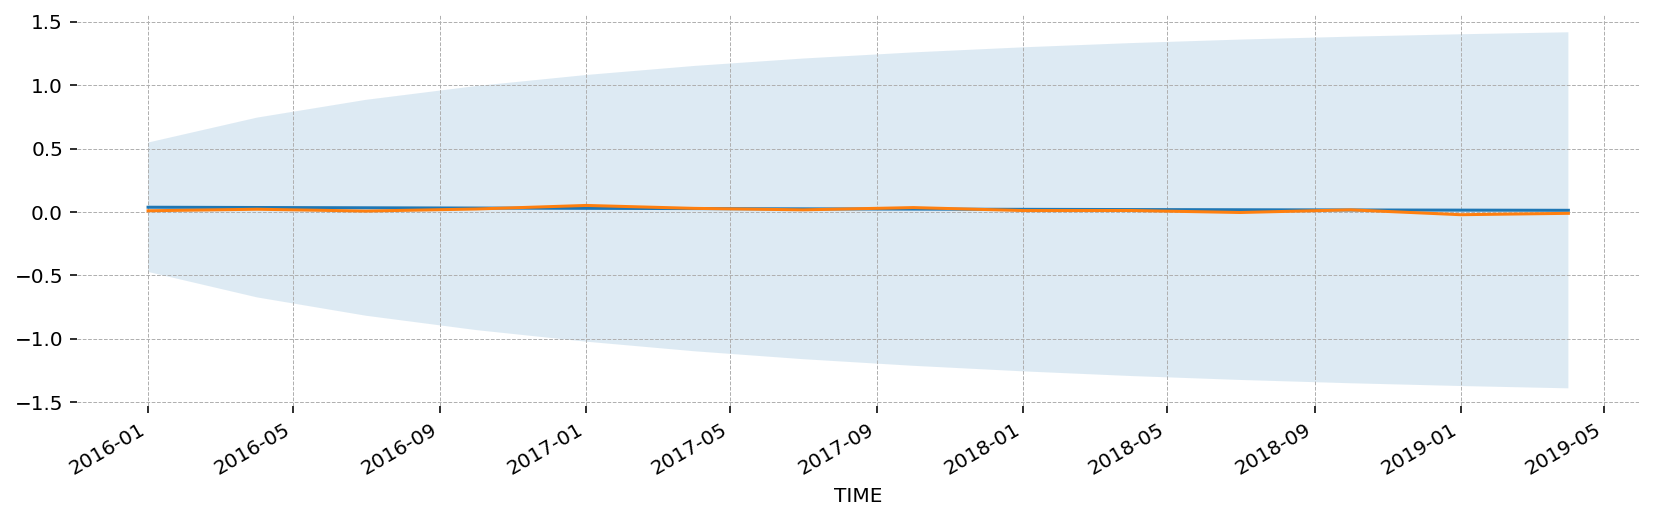

In [21]:
mu = mle_forecast.predicted_mean

# var_pred_mean is the variance, but the 95% CI will be +/- 1.96 * std, so we have to take square root.
sigma = 1.96 * np.sqrt(mle_forecast.var_pred_mean)

fig, ax = plt.subplots()
ax.plot(mu)
ax.fill_between(mu.index, mu - sigma, mu + sigma, alpha=0.15)
test.Y.plot(ax=ax)
plt.show()

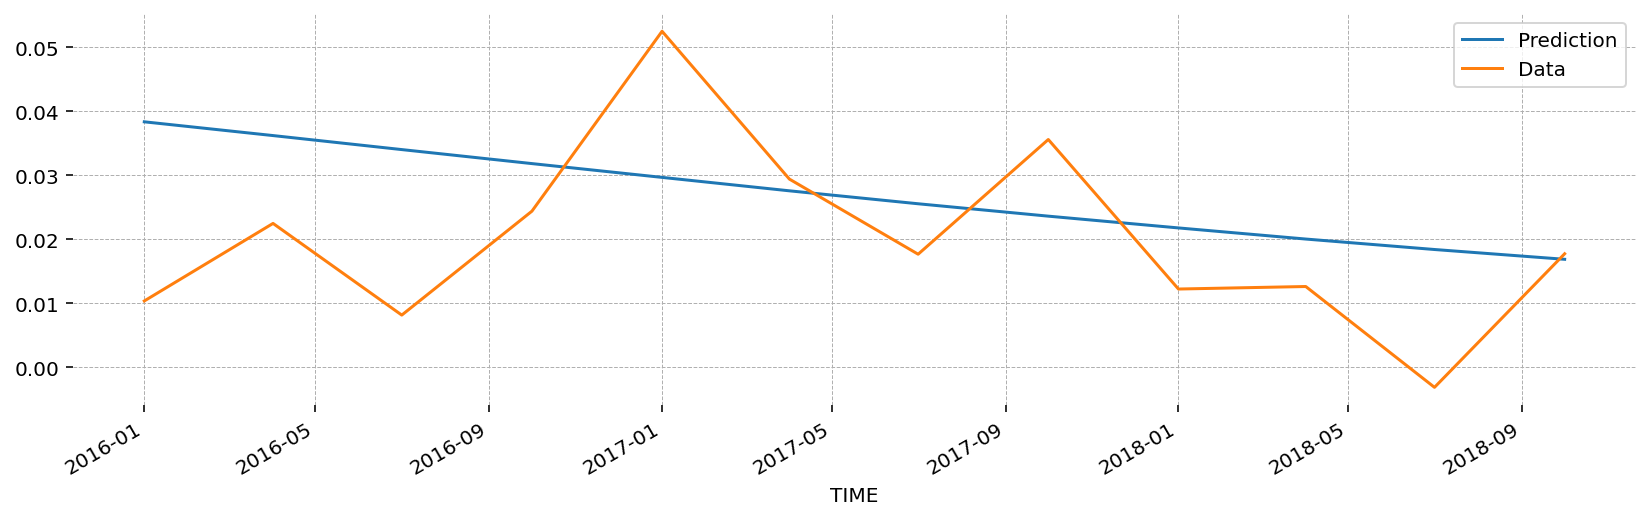

In [22]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

Our model has not correctly captured the notion of an overbooming economy, that evenutally declines. This could be an interpretation of the down-turn in 2017, which has been preceeded by years of recovery and subsquent boom of post 08. However, the model did identify a decline in Y, at least at mean prediction the confidence interval is far too broad to qualify for this to qualify as an actual prediction.

## Analysing sigma_C <a class="anchor" id="section_4_2"></a>

To address the high volatility of C in the Kalman Filter predictions we include sigma_C, the consumption utility parameter. As consumption is too responsive, the chosen parameter for sigma_C might be too low (implying higher repsonsiveness of C).

In [23]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [33]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85,
    'sigma_C': 1
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
    'Y':0.01
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
    'sigma_C':IntervalTransformer(low=1, high=10, slope=1)
                    }

mle_mod = MLEModel(train[["Y"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [ ]:
%%capture
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=maxiter)

In [ ]:
mle_res.summary()

Indeed we see that the parameter for sigma_C that has been identified by the model is much higher than what was suggested by the literature. This could be an explanation for the odd behaviour of the Consumption function.

### MLE Kalman Filter Prediction Plots <a class="anchor" id="section_4_3"></a>

Predictions

Looking at the output of the the prediction including sigma_C this theory cannot be confirmed. Even though sigma_C has been calibrated more "correctly" (if we believe the Kalman filter's findings) the effect on our prediction of consumption and labour is negligble. Confidence bands for L and I actually have increased and the mean prediction has also not managed to approximate underlying data more accurately.

In [ ]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

In [ ]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="section_4_4"></a>

In [ ]:
mle_forecast = mle_res.get_forecast(steps=test_size)

In [ ]:
mu = mle_forecast.predicted_mean

# var_pred_mean is the variance, but the 95% CI will be +/- 1.96 * std, so we have to take square root.
sigma = 1.96 * np.sqrt(mle_forecast.var_pred_mean)

fig, ax = plt.subplots()
ax.plot(mu)
ax.fill_between(mu.index, mu - sigma, mu + sigma, alpha=0.15)
test.Y.plot(ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

Forecasting results are very similar to the baseline simple model.

## Adding L  <a class="anchor" id="section_4_3"></a>

We now include labour into the model to see whether this leads to any improvement with regards to our Consumption prediction. As Labour and Consumption are directly related in their choosing (through the Euler Equation) more information on Labour might help us predict consumption more accurately. We do not include sigma_L just yet, since it has actually a very small effect on consumer choice?

In [ ]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [ ]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85,
    'sigma_C': 1
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
    'Y':0.01
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
    'sigma_C':IntervalTransformer(low=1, high=10, slope=1)
                    }

mle_mod = MLEModel(train[["Y", "L"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [ ]:
%%capture
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=maxiter)

In [ ]:
mle_res.summary()

### MLE Kalman Filter Prediction Plots <a class="anchor" id="section_4_5"></a>

Predictions

The inclusion of C has lead to no improvement, neither have confidence intervals decreased nor are mean predictions any closer to the underlying data. If at all the inclusion of L has worsened the prediction of L as the model now closely follows L instead of Y.

In [ ]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

In [ ]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="subsection_4_6"></a>

In [ ]:
everything_forecast = mle_res.get_forecast(steps=test_size)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'L'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

## Adding C  <a class="anchor" id="section_4_3"></a>

We include labour into the model to see whether also predictions for C improve

In [ ]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [ ]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85,
    'sigma_C': 1
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
    'Y':0.01
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
    'sigma_C':IntervalTransformer(low=1, high=10, slope=1)
                    }

mle_mod = MLEModel(train[["Y", "C"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [ ]:
%%capture
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=maxiter)

In [ ]:
mle_res.summary()

### MLE Kalman Filter Prediction Plots <a class="anchor" id="section_4_5"></a>

Predictions

Including C into the model has show positive effects. Confidence intervals decreased, the model thus seems to have taken something from this additional data source. Yet predictions are in no way more meaningful when compared to before. Consumption this time is closly fitted, yet other variables such as Y suffer in accuracy, even though not as much as with the inclusion of L.

In [ ]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

In [ ]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="subsection_4_6"></a>

In [ ]:
everything_forecast = mle_res.get_forecast(steps=test_size)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'C'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

## Final model <a class="anchor" id="section_4_4"></a>

Having gradually added data to the Kalman filter estimation we are now running the model on the complete data available to us. 

In [ ]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [ ]:
# Try estimating everything, why not?
param_start_dict = {'rho_A':0.85,
                    'sigma_C':1,
                    'sigma_L':1,
                    'alpha':0.35,
                    'beta':0.98,
                    'delta':0.035}

shock_start_dict = {'epsilon_A':0.5}

# We have to add noise to everything but Y, or else we'll get the stochastic singularity
noise_start_dict = {'L':0.01,
                    'w':0.01,
                    'r':0.01,
                    'C':0.01,
                    'I':0.01}

param_transforms = {'rho_A':IntervalTransformer(low=0.01, high=0.99),
                    'sigma_C':IntervalTransformer(low=1.0, high=10.0),
                    'sigma_L':IntervalTransformer(low=1.0, high=10),
                    'alpha':IntervalTransformer(low=0.1, high=0.5),
                    'beta':IntervalTransformer(low=0.9, high=0.999),
                    'delta':IntervalTransformer(low=0.01, high=0.05)}

# Build the model!
mle_mod = MLEModel(train[['Y', 'L', 'w', 'r', 'C', 'I']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [ ]:
%%capture
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=maxiter)

In [ ]:
mle_res.summary()

### MLE Kalman Filter Prediction Plots <a class="anchor" id="section_4_7"></a>

Predictions

Including all to us available data into the model has lead to some improvement. Confidence intervals have significantly decreased (I does no longer lie in a range of +/- 1000%). However, other anomalies become apparent. The actual consumption data lies without the confidence interval of the model's prediction, hence are considered impossible values. Moreover prediction power on the other variables has not improved, only Y has the close fitting of prediction like in the baseline model.

In [ ]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

In [ ]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="section_4_8"></a>

In [ ]:
mle_forecast = mle_res.get_forecast(steps=test_size)
mu = mle_forecast.predicted_mean

In [ ]:
n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'w', 'r', 'C', 'I'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

Our model has not correctly captured the notion of an overbooming economy, that evenutally declines. This could be an interpretation of the down-turn in 2017, which has been preceeded by years of recovery and subsquent boom of post 08.

## Impulse response <a class="anchor" id="section_4_5"></a>

In [ ]:
irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

In [ ]:
fig = gp.plot_irf(irf.rename(columns={'epsilon_A':'MLE Estimate'}), vars_to_plot=plot_vars)
fig2 = gp.plot_irf(base_irf, vars_to_plot=plot_vars)

for axis, axis2 in zip(fig.axes, fig2.axes):
    line = axis2.get_children()[0]
    axis.plot(line.get_data()[0], line.get_data()[1], color='tab:orange', label='Initial Values')

    
fig.axes[0].legend()
fig2.clear()
fig2.set_visible(False)
plt.show()

### New Steady State <a class="anchor" id="subsection_4_9"></a>

The new steady state has significantly higher capital K_ss and Y_ss as the ex-ante model.

In [ ]:
rbc.print_steady_state()